<a href="https://colab.research.google.com/github/mbarte/AMD/blob/main/GCCategorical_TL_AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **GALAXY CLASSIFICATION TASK - TRANSFER LEARNING**

https://keras.io/guides/transfer_learning/#:~:text=Freeze%20all%20layers%20in%20the%20base%20model%20by%20setting%20trainable%20%3D%20False%20.

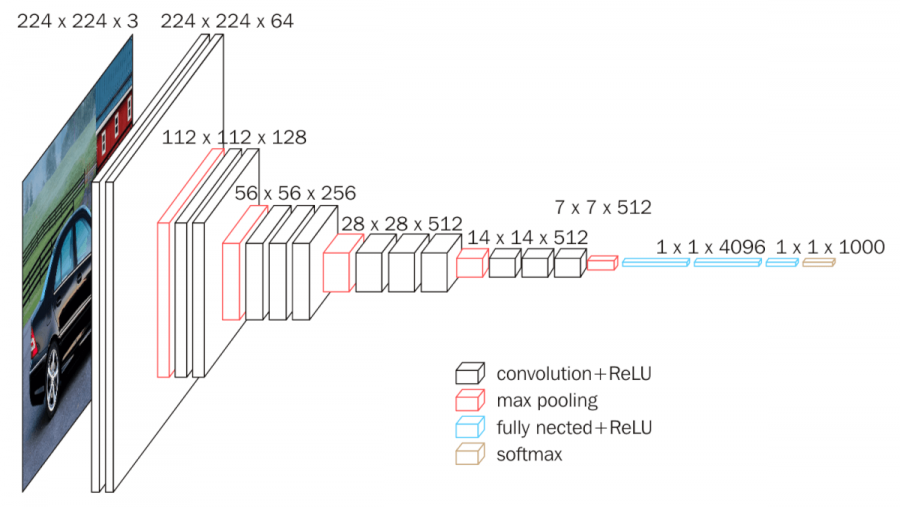

Image credits:https://neurohive.io/en/

We finally use transfer learning on binary classification task to see which level of accuracy we can get.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Import the necessary libraries

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from numpy import asarray
import os
import copy
import time
import itertools
import h5py
from PIL import Image
import cv2
from random import sample, seed

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import PIL #import pillow 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers, metrics, losses, callbacks, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
strategy = tf.distribute.get_strategy()
strategy

# Fully automatic import [Run this to download and unzip the dataset]

In [ ]:
os.environ['KAGGLE_USERNAME'] = "michelebarte" 
os.environ['KAGGLE_KEY'] = "85bdd7673d63f1cd611f2e4cab0e1f6e" 

#Download
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

print("Downloading done!")

 99% 1.76G/1.77G [00:13<00:00, 186MB/s]
100% 1.77G/1.77G [00:13<00:00, 143MB/s]


In [ ]:
#Unzip
start = time.time()

!unzip /content/galaxy-zoo-the-galaxy-challenge.zip                             #-d /content/<folder name> to create a specific folder 

end = time.time()
print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

Archive:  /content/galaxy-zoo-the-galaxy-challenge.zip
  inflating: all_ones_benchmark.zip  
  inflating: all_zeros_benchmark.zip  
  inflating: central_pixel_benchmark.zip  
  inflating: images_test_rev1.zip    
  inflating: images_training_rev1.zip  
  inflating: training_solutions_rev1.zip  
Unzipping done!
The process took 0.01 hours.


In [ ]:
%%capture                                                                       
#suppress the "inflating filename..." output

start = time.time()

!unzip /content/images_training_rev1.zip                                        #unzip training data
!unzip /content/images_test_rev1.zip                                            #unzip testing data
!unzip /content/training_solutions_rev1.zip                                     #unzip training labels

end = time.time()

print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

# Functions

In [ ]:
BATCH_SIZE = 128                                                            
#The batch size can be made smaller so that the model will do less coarse steps in order to look for the optimal solution and is more likely to converge to it
#For computational reasons we use a larger one

AUTOTUNE = tf.data.AUTOTUNE     

In [ ]:
path = "/content/images_training_rev1/"

- Function to turn to categorical framework

In [ ]:
def to_categorical(labels):
  '''
  takes the labels as an input and convert the dataframe into a dictionary containing 26 classes for a categorical classification problem
  '''
  lb = labels.iloc[:,1:]   #values only
  id = labels.iloc[:,0]    #id's only

  class1 = lb.iloc[:,0:3]
  class2 = lb.iloc[:,3:5]
  class3 = lb.iloc[:,5:7]
  class4 = lb.iloc[:,7:9]
  class5 = lb.iloc[:,9:13]
  class6 = lb.iloc[:,13:15]
  class7 = lb.iloc[:,15:18]
  class8 = lb.iloc[:,18:25]
  class9 = lb.iloc[:,25:28]
  class10 = lb.iloc[:,28:31]
  class11 = lb.iloc[:,31:37]

  cat_labels = {}                                                             #dictionary storing galaxyID: categorical label
  #for i in labels["GalaxyID"]:
  for i in range(len(labels)):
    
    #---------------------------------------------------------------------------
    if class1.iloc[i].idxmax() == "Class1.3":  #se non è nè tonda nè a spirale
      cat_labels[id[i]] = "With feature/disk"   #non è una galassia
    #---------------------------------------------------------------------------
    elif class1.iloc[i].idxmax() == "Class1.1":    #se è smooth
      cat_labels[id[i]] ="Smooth"
      
    elif class1.iloc[i].idxmax() == "Class1.2":    #galassia, ma non smooth
      cat_labels[id[i]] = "With feature/disk" 
    
  return cat_labels

#TODO: Future work: re-write this function in an efficient way

- Functions to prepare the datasets

In [ ]:
#Create images (X) and labels datasets
def my_X_train(final, X_train):
  '''
  takes the dataset with id's and OneHotEncoded labels 
  X_train containing id's turns it into a dataset with corresponding images
  '''
  images = []
  
  for id in X_train["GalaxyID"]:
    path = "/content/images_training_rev1/"
    extension = ".jpg"
    img = Image.open(path + str(id) + extension)
    img = asarray(img)
    img = img[137:287, 137:287]                                                 #retain the central 150x150 pixels to exclude other galaxies
    img = cv2.resize(img, (100,100))                                              #resize to make training faster
    #norm = np.zeros((50,50))
    #img = cv2.normalize(img, norm, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    images.append(img) 

  images = np.array(images)    #required to make vgg work
  return images
    

def my_y_train(final, y_train):

  labels = []
  for id in y_train["GalaxyID"]:
    row = final.loc[final["GalaxyID"] == id]                                      #retrieve the corresponding row in the labels dataframe
    lbl = np.asarray(row.iloc[0,:2].values, dtype = np.uint8)
    labels.append(lbl)

  labels = np.array(labels)     #required to make vgg work
  
  return labels

- Function to schedule the learning rate decrease

In [ ]:
def decay_schedule(epoch, lr):
    return lr * 0.8 if (epoch % 10 == 0) and (epoch != 0) else lr

# Preprocessing



The first part is analogous to the main notebook

In [ ]:
files_list = os.listdir("/content/images_training_rev1/")                       #easier to work with strings instead of Tensors in this case

#seed(123)
#sample_size = int(len(files_list)*0.5)
#files_list = sample(files_list, sample_size)                                    #using 50% of the files (~30 thousands images)
print("We are now working with: ", len(files_list), " files")
files_list[:3]

We are now working with:  61578  files


['254821.jpg', '322374.jpg', '121694.jpg']

In [ ]:
#Inspect the training labels and find the one corresponding to the extracted sample
labels = pd.read_csv("/content/training_solutions_rev1.zip")
print("The shape of the dataframe was: ", labels.shape)
labels.head()

The shape of the dataframe was:  (61578, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
#Retrieve labels corresponding to the images drawn in the sample
ids = []
for file in files_list:                                    
  id = int(file[:-4])
  ids.append(id)

labels = labels[labels["GalaxyID"].isin(ids)]


In [ ]:
labels.reset_index(inplace = True, drop = True)

In [ ]:
print("The shape of the dataframe is: ", labels.shape) 
labels.head()

The shape of the dataframe is:  (61578, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
#Convert into categorical labels (26 classes)
cat_labels = to_categorical(labels)

In [ ]:
#Create a dataframe from the dictionary
categorical_data = pd.DataFrame.from_dict(cat_labels, orient = "index", columns = ["LABEL"])

#Create a column containing the index, namely the GalaxyID and reset the index to count the rows
categorical_data["GalaxyID"] = categorical_data.index
categorical_data.reset_index(drop=True)
categorical_data.head() 

,LABEL,GalaxyID
100008,With feature/disk,100008
100023,With feature/disk,100023
100053,Smooth,100053
100078,Smooth,100078
100090,Smooth,100090


In [ ]:
len(categorical_data)    #we "lost" 28 galaxies due to generalisation

61578

In [ ]:
#Create a list with the ID of the galaxies without categorical label
missing = []
for file in files_list:
  id = int(file[:-4])      
  if id not in categorical_data["GalaxyID"]:                                  
    missing.append(id)

print("The number of the galaxies without categorical label is the difference between the total number of files and the number of galaxies in categorical_data: ",
      len(missing) == len(files_list) - len(categorical_data))
missing[:10]

#TODO: make it more efficient

The number of the galaxies without categorical label is the difference between the total number of files and the number of galaxies in categorical_data:  True


[]

In [ ]:
#retrieve the name of the file starting from the ID and delete it from the list of files that will be used to train and test the model
print("Total number of elements before: ", len(files_list))
for i in range(len(missing)):
  filename = str(missing[i]) + ".jpg"
  files_list.remove(filename)
  print(filename, "removed successfully!")
print("Total number of elements after: ", len(files_list))

Total number of elements before:  61578
Total number of elements after:  61578


In [ ]:
#Create the dummy variables
pd.set_option('display.max_columns', False)
one_hot = pd.get_dummies(categorical_data['LABEL'])
one_hot.head()

,Smooth,With feature/disk
100008,0,1
100023,0,1
100053,1,0
100078,1,0
100090,1,0


In [ ]:
#Obtain the final dataset containing: GalaxyID and 26 columns corresponding to thge 26 classes and 0-1 entries to encode the class each galaxy belongs to
final = pd.merge(one_hot, categorical_data, left_index =  True, right_on = "GalaxyID")
final.drop(columns="LABEL", inplace = True)
final = final.reset_index(drop=True)
final.head()

,Smooth,With feature/disk,GalaxyID
0,0,1,100008
1,0,1,100023
2,1,0,100053
3,1,0,100078
4,1,0,100090


In [ ]:
counts = pd.DataFrame(categorical_data.groupby("LABEL").count())
counts.columns = ["count"]
counts["LABEL"] = counts.index
counts.reset_index(inplace = True, drop = True)
counts

,count,LABEL
0,26693,Smooth
1,34885,With feature/disk


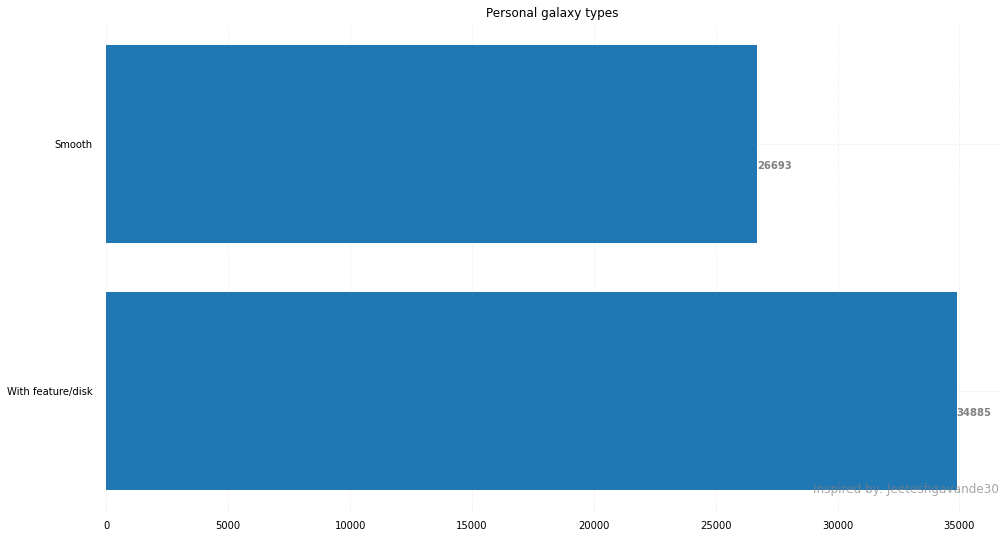

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(counts["LABEL"], counts["count"])
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Personal galaxy types' )
 
# Add Text watermark
fig.text(0.9, 0.15, 'Inspired by: Jeeteshgavande30', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

We can now split the data stratifying labels

In [ ]:
#Manually stratifying labels
train = categorical_data.groupby("LABEL", group_keys = False).apply(lambda x: x.sample(frac = 0.7, random_state = 1))
remaining = categorical_data.drop(train.index)
validation = remaining.groupby("LABEL", group_keys = False).apply(lambda x: x.sample(frac = 0.7, random_state = 1))
test = remaining.drop(validation.index)

In [ ]:
X_train = my_X_train(final, train)
y_train = my_y_train(final, train)

In [ ]:
len(X_train), len(y_train)

(43105, 43105)

In [ ]:
X_test = my_X_train(final, test)
y_test = my_y_train(final, test)

In [ ]:
len(X_test), len(y_test)

(5542, 5542)

In [ ]:
X_val = my_X_train(final, validation)
y_val = my_y_train(final, validation)

In [ ]:
len(X_val), len(y_val)

(12931, 12931)

# Model [Do not run]

**Attempts**:
- Xception with (current): image size must be at least 71x71
- vgg16
- DenseNet121
- InceptionV3

In [ ]:
dnt = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=X_train[0].shape, classifier_activation = "sofmax")
dnt.trainable = False 
dnt.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_7[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

After importing it, we customise the model so that the last layer matches the number of classes specific to our application. We also add data augmentation techniques to increase the power of generalisation, exploiting the rotational invariance of galaxy images

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [ ]:
inputs = keras.Input(shape=(100, 100, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 255.0, offset=-1)
x = data_augmentation(inputs) 
x = scale_layer(x)
x = dnt(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2)(x)
dnt = keras.Model(inputs, outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) 

loss_func = tf.keras.losses.CategoricalCrossentropy() 

dnt.compile(loss=loss_func, optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy()]) 
dnt.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_3 (Dropout)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 36866     
                                                                 
Total params: 20,898,346
Trainable params: 36,866
Non-trainable params: 20,861,480
_________________________________________________________________


Deploy the usual CallBacks to optimise the traning process

In [ ]:
num_epochs = 10
verbose = True

# Callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-3)

lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)

early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_categorical_accuracy', mode='max')   

callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

Train the model

1st, 2nd, 3rd rounds

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = dnt.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - ETA: 0s - loss: 0.5443 - categorical_accuracy: 0.7533

337/337 [==============================] - 1180s 4s/step - loss: 0.5443 - categorical_accuracy: 0.7533 - val_loss: 0.5182 - val_categorical_accuracy: 0.7616 - lr: 1.0000e-05
Epoch 2/10
337/337 [==============================] - 1129s 3s/step - loss: 0.5427 - categorical_accuracy: 0.7462 - val_loss: 0.5326 - val_categorical_accuracy: 0.7601 - lr: 1.0000e-05
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 0.5379 - categorical_accuracy: 0.7537

337/337 [==============================] - 1157s 3s/step - loss: 0.5379 - categorical_accuracy: 0.7537 - val_loss: 0.5200 - val_categorical_accuracy: 0.7651 - lr: 1.0000e-05
Epoch 4/10
337/337 [==============================] - ETA: 0s - loss: 0.5420 - categorical_accuracy: 0.7589

337/337 [==============================] - 1151s 3s/step - loss: 0.5420 - categorical_accuracy: 0.7589 - val_loss: 0.5144 - val_categorical_accuracy: 0.7654 - lr: 1.0000e-05
Epoch 5/10
337/337 [==============================] - ETA: 0s - loss: 0.5350 - categorical_accuracy: 0.7581

337/337 [==============================] - 1148s 3s/step - loss: 0.5350 - categorical_accuracy: 0.7581 - val_loss: 0.5131 - val_categorical_accuracy: 0.7671 - lr: 1.0000e-05
Epoch 6/10
337/337 [==============================] - 1130s 3s/step - loss: 0.5356 - categorical_accuracy: 0.7585 - val_loss: 0.5327 - val_categorical_accuracy: 0.7625 - lr: 1.0000e-05
Epoch 7/10
337/337 [==============================] - ETA: 0s - loss: 0.5293 - categorical_accuracy: 0.7605

337/337 [==============================] - 1159s 3s/step - loss: 0.5293 - categorical_accuracy: 0.7605 - val_loss: 0.5217 - val_categorical_accuracy: 0.7683 - lr: 1.0000e-05
Epoch 8/10
337/337 [==============================] - ETA: 0s - loss: 0.5254 - categorical_accuracy: 0.7605

337/337 [==============================] - 1151s 3s/step - loss: 0.5254 - categorical_accuracy: 0.7605 - val_loss: 0.5126 - val_categorical_accuracy: 0.7688 - lr: 1.0000e-05
Epoch 9/10
337/337 [==============================] - ETA: 0s - loss: 0.5306 - categorical_accuracy: 0.7622

337/337 [==============================] - 1149s 3s/step - loss: 0.5306 - categorical_accuracy: 0.7622 - val_loss: 0.5152 - val_categorical_accuracy: 0.7709 - lr: 1.0000e-05
Epoch 10/10
337/337 [==============================] - 1134s 3s/step - loss: 0.5247 - categorical_accuracy: 0.7646 - val_loss: 0.5116 - val_categorical_accuracy: 0.7695 - lr: 1.0000e-05
Total training took 3.21 hours.


This test was done after 3 rounds of training of 10 epochs each

In [ ]:
#test the model

results = dnt.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 108s 622ms/step - loss: 0.5016 - categorical_accuracy: 0.7772
Test accuracy: 0.777


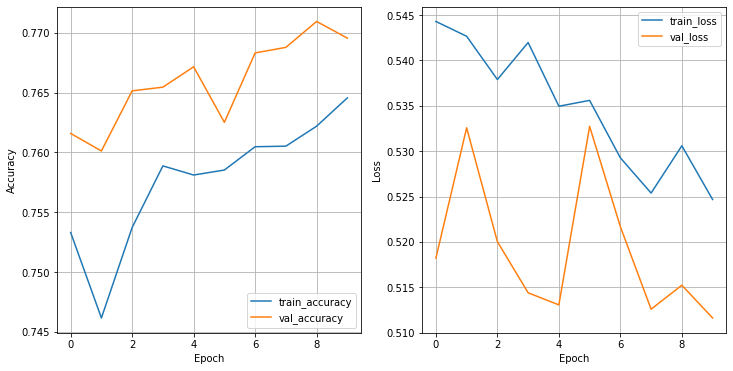

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

The original images on which the model was trained (imagenet dataset) are distant from our images, therefore the models performs worse than expected. 

In [ ]:
# save model and architecture to single file
dnt.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


4-th round

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = dnt.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - 1127s 3s/step - loss: 0.5288 - categorical_accuracy: 0.7626 - val_loss: 0.5140 - val_categorical_accuracy: 0.7699 - lr: 1.0000e-05
Epoch 2/10
337/337 [==============================] - 1121s 3s/step - loss: 0.5289 - categorical_accuracy: 0.7565 - val_loss: 0.5228 - val_categorical_accuracy: 0.7684 - lr: 1.0000e-05
Epoch 3/10
337/337 [==============================] - 1139s 3s/step - loss: 0.5249 - categorical_accuracy: 0.7628 - val_loss: 0.5167 - val_categorical_accuracy: 0.7702 - lr: 1.0000e-05
Epoch 4/10
337/337 [==============================] - 1121s 3s/step - loss: 0.5249 - categorical_accuracy: 0.7640 - val_loss: 0.5126 - val_categorical_accuracy: 0.7705 - lr: 1.0000e-05
Epoch 5/10
337/337 [==============================] - 1123s 3s/step - loss: 0.5285 - categorical_accuracy: 0.7661 - val_loss: 0.5090 - val_categorical_accuracy: 0.7706 - lr: 1.0000e-05
Epoch 6/10
337/337 [==============================

337/337 [==============================] - 1163s 3s/step - loss: 0.5275 - categorical_accuracy: 0.7664 - val_loss: 0.5071 - val_categorical_accuracy: 0.7724 - lr: 1.0000e-05
Epoch 7/10
337/337 [==============================] - ETA: 0s - loss: 0.5343 - categorical_accuracy: 0.7652

337/337 [==============================] - 1166s 3s/step - loss: 0.5343 - categorical_accuracy: 0.7652 - val_loss: 0.5063 - val_categorical_accuracy: 0.7731 - lr: 1.0000e-05
Epoch 8/10
337/337 [==============================] - 1205s 4s/step - loss: 0.5294 - categorical_accuracy: 0.7665 - val_loss: 0.5082 - val_categorical_accuracy: 0.7729 - lr: 1.0000e-05
Epoch 9/10
337/337 [==============================] - 1201s 4s/step - loss: 0.5189 - categorical_accuracy: 0.7665 - val_loss: 0.5088 - val_categorical_accuracy: 0.7730 - lr: 1.0000e-05
Epoch 10/10
337/337 [==============================] - 1141s 3s/step - loss: 0.5215 - categorical_accuracy: 0.7665 - val_loss: 0.5114 - val_categorical_accuracy: 0.7697 - lr: 1.0000e-05
Total training took 3.20 hours.


In [ ]:
#test the model

results = dnt.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 111s 637ms/step - loss: 0.5030 - categorical_accuracy: 0.7784
Test accuracy: 0.778


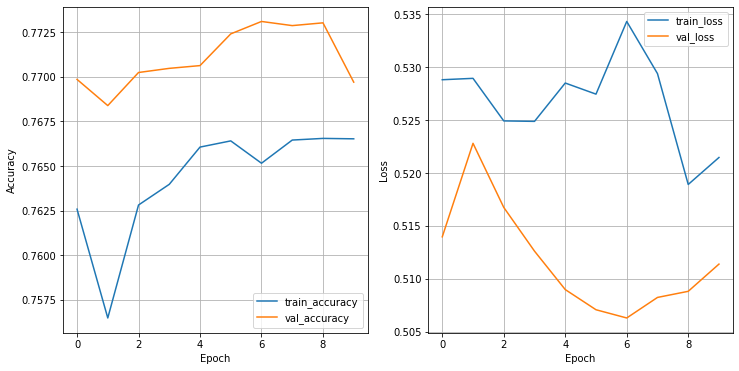

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
dnt.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


5th round

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = dnt.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - ETA: 0s - loss: 0.5213 - categorical_accuracy: 0.7661

337/337 [==============================] - 1150s 3s/step - loss: 0.5213 - categorical_accuracy: 0.7661 - val_loss: 0.5110 - val_categorical_accuracy: 0.7737 - lr: 1.0000e-05
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 0.5160 - categorical_accuracy: 0.7676

337/337 [==============================] - 1180s 4s/step - loss: 0.5160 - categorical_accuracy: 0.7676 - val_loss: 0.5087 - val_categorical_accuracy: 0.7739 - lr: 1.0000e-05
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 0.5165 - categorical_accuracy: 0.7664

337/337 [==============================] - 1237s 4s/step - loss: 0.5165 - categorical_accuracy: 0.7664 - val_loss: 0.5083 - val_categorical_accuracy: 0.7743 - lr: 1.0000e-05
Epoch 4/10
337/337 [==============================] - ETA: 0s - loss: 0.5193 - categorical_accuracy: 0.7671

337/337 [==============================] - 1164s 3s/step - loss: 0.5193 - categorical_accuracy: 0.7671 - val_loss: 0.5076 - val_categorical_accuracy: 0.7745 - lr: 1.0000e-05
Epoch 5/10
337/337 [==============================] - ETA: 0s - loss: 0.5147 - categorical_accuracy: 0.7683

337/337 [==============================] - 1169s 3s/step - loss: 0.5147 - categorical_accuracy: 0.7683 - val_loss: 0.5087 - val_categorical_accuracy: 0.7750 - lr: 1.0000e-05
Epoch 6/10
337/337 [==============================] - 1150s 3s/step - loss: 0.5189 - categorical_accuracy: 0.7689 - val_loss: 0.5082 - val_categorical_accuracy: 0.7748 - lr: 1.0000e-05
Epoch 7/10
337/337 [==============================] - 1148s 3s/step - loss: 0.5150 - categorical_accuracy: 0.7701 - val_loss: 0.5093 - val_categorical_accuracy: 0.7750 - lr: 1.0000e-05
Epoch 8/10
337/337 [==============================] - ETA: 0s - loss: 0.5159 - categorical_accuracy: 0.7655

337/337 [==============================] - 1171s 3s/step - loss: 0.5159 - categorical_accuracy: 0.7655 - val_loss: 0.5078 - val_categorical_accuracy: 0.7759 - lr: 1.0000e-05
Epoch 9/10
337/337 [==============================] - 1201s 4s/step - loss: 0.5213 - categorical_accuracy: 0.7657 - val_loss: 0.5189 - val_categorical_accuracy: 0.7654 - lr: 1.0000e-05
Epoch 9: early stopping
Total training took 2.94 hours.


In [ ]:
#test the model

results = dnt.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 110s 631ms/step - loss: 0.5130 - categorical_accuracy: 0.7719
Test accuracy: 0.772


Slight decrease in test accuracy

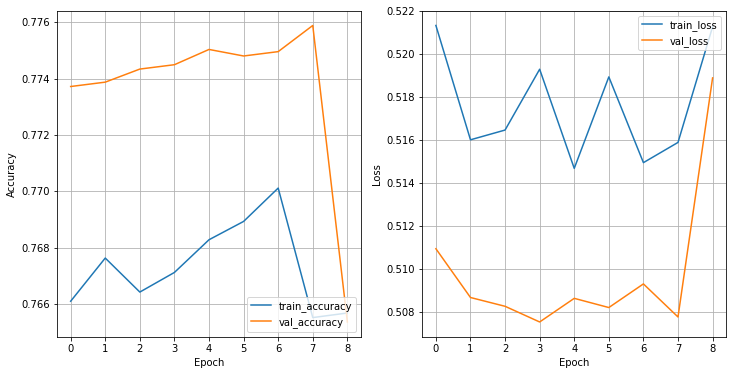

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
dnt.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


6th round 

achieved a 78.6% test accuracy, but while training through epochs 60 to 70 the runtime disconnected: load the model and do again the last 10 epochs

Load model 

In [ ]:
from google.colab import files
restored = files.upload()

Saving dnt.h5 to dnt.h5


In [ ]:
reconstructed_model = keras.models.load_model("dnt.h5")

In [ ]:
num_epochs = 10
verbose = True

# Callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)

early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_categorical_accuracy', mode='max')   

callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

7-th round

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = reconstructed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - ETA: 0s - loss: 0.5138 - categorical_accuracy: 0.7689

337/337 [==============================] - 1142s 3s/step - loss: 0.5138 - categorical_accuracy: 0.7689 - val_loss: 0.5166 - val_categorical_accuracy: 0.7755 - lr: 1.0000e-05
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 0.5215 - categorical_accuracy: 0.7707

337/337 [==============================] - 1175s 3s/step - loss: 0.5215 - categorical_accuracy: 0.7707 - val_loss: 0.5149 - val_categorical_accuracy: 0.7779 - lr: 1.0000e-05
Epoch 3/10
337/337 [==============================] - 1142s 3s/step - loss: 0.5191 - categorical_accuracy: 0.7728 - val_loss: 0.5159 - val_categorical_accuracy: 0.7753 - lr: 1.0000e-05
Epoch 4/10
337/337 [==============================] - ETA: 0s - loss: 0.5157 - categorical_accuracy: 0.7738

337/337 [==============================] - 1139s 3s/step - loss: 0.5157 - categorical_accuracy: 0.7738 - val_loss: 0.5119 - val_categorical_accuracy: 0.7802 - lr: 1.0000e-05
Epoch 5/10
337/337 [==============================] - 1135s 3s/step - loss: 0.5167 - categorical_accuracy: 0.7719 - val_loss: 0.5073 - val_categorical_accuracy: 0.7770 - lr: 1.0000e-05
Epoch 6/10
337/337 [==============================] - 1124s 3s/step - loss: 0.5204 - categorical_accuracy: 0.7726 - val_loss: 0.5083 - val_categorical_accuracy: 0.7761 - lr: 1.0000e-05
Epoch 7/10
337/337 [==============================] - 1114s 3s/step - loss: 0.5153 - categorical_accuracy: 0.7742 - val_loss: 0.5041 - val_categorical_accuracy: 0.7784 - lr: 1.0000e-05
Epoch 8/10
337/337 [==============================] - 1109s 3s/step - loss: 0.5210 - categorical_accuracy: 0.7738 - val_loss: 0.5167 - val_categorical_accuracy: 0.7641 - lr: 1.0000e-05
Epoch 9/10
337/337 [==============================] - 1115s 3s/step - loss: 0.5153 - c

In [ ]:
#test the model

results = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 106s 607ms/step - loss: 0.4911 - categorical_accuracy: 0.7846
Test accuracy: 0.785


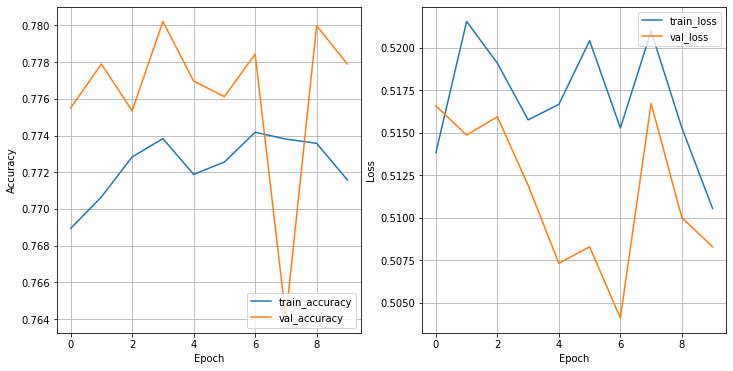

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
reconstructed_model.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files
files.download('dnt.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8-th round

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = reconstructed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - 1097s 3s/step - loss: 0.5056 - categorical_accuracy: 0.7738 - val_loss: 0.5050 - val_categorical_accuracy: 0.7791 - lr: 2.0000e-06
Epoch 2/10
337/337 [==============================] - 1101s 3s/step - loss: 0.5070 - categorical_accuracy: 0.7735 - val_loss: 0.5040 - val_categorical_accuracy: 0.7784 - lr: 2.0000e-06
Epoch 3/10
337/337 [==============================] - 1110s 3s/step - loss: 0.5071 - categorical_accuracy: 0.7738 - val_loss: 0.5043 - val_categorical_accuracy: 0.7787 - lr: 2.0000e-06
Epoch 4/10
337/337 [==============================] - 1101s 3s/step - loss: 0.5083 - categorical_accuracy: 0.7725 - val_loss: 0.5059 - val_categorical_accuracy: 0.7800 - lr: 2.0000e-06
Epoch 5/10
337/337 [==============================] - 1099s 3s/step - loss: 0.5079 - categorical_accuracy: 0.7752 - val_loss: 0.5062 - val_categorical_accuracy: 0.7794 - lr: 1.0000e-06
Epoch 6/10
337/337 [==============================

In [ ]:
#test the model

results = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 106s 609ms/step - loss: 0.4878 - categorical_accuracy: 0.7869
Test accuracy: 0.787


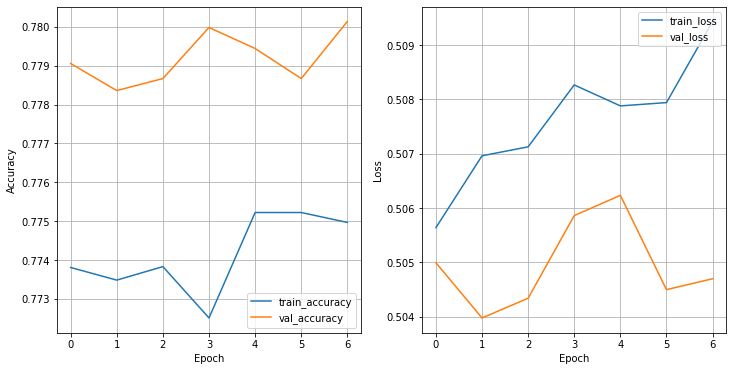

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
reconstructed_model.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#Automatically download the file
from google.colab import files
files.download('dnt.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9-th round

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = reconstructed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - 1158s 3s/step - loss: 0.5085 - categorical_accuracy: 0.7744 - val_loss: 0.5052 - val_categorical_accuracy: 0.7797 - lr: 1.0000e-06
Epoch 2/10
337/337 [==============================] - 1133s 3s/step - loss: 0.5077 - categorical_accuracy: 0.7745 - val_loss: 0.5041 - val_categorical_accuracy: 0.7791 - lr: 1.0000e-06
Epoch 3/10
337/337 [==============================] - 1086s 3s/step - loss: 0.5059 - categorical_accuracy: 0.7754 - val_loss: 0.5031 - val_categorical_accuracy: 0.7791 - lr: 1.0000e-06
Epoch 4/10
337/337 [==============================] - 1097s 3s/step - loss: 0.5067 - categorical_accuracy: 0.7750 - val_loss: 0.5035 - val_categorical_accuracy: 0.7789 - lr: 1.0000e-06
Epoch 5/10
337/337 [==============================] - 1083s 3s/step - loss: 0.5046 - categorical_accuracy: 0.7754 - val_loss: 0.5044 - val_categorical_accuracy: 0.7798 - lr: 1.0000e-06
Epoch 6/10
337/337 [==============================

In [ ]:
#test the model

results = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 104s 599ms/step - loss: 0.4844 - categorical_accuracy: 0.7864
Test accuracy: 0.786


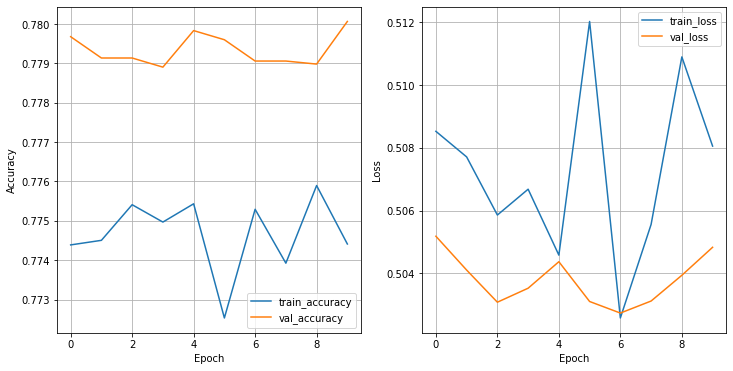

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
reconstructed_model.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files
files.download('dnt.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10-th round = 100 epochs

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = reconstructed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - 1095s 3s/step - loss: 0.5062 - categorical_accuracy: 0.7770 - val_loss: 0.5065 - val_categorical_accuracy: 0.7795 - lr: 1.0000e-06
Epoch 2/10
337/337 [==============================] - 1097s 3s/step - loss: 0.5103 - categorical_accuracy: 0.7749 - val_loss: 0.5068 - val_categorical_accuracy: 0.7800 - lr: 1.0000e-06
Epoch 3/10
337/337 [==============================] - 1109s 3s/step - loss: 0.5096 - categorical_accuracy: 0.7770 - val_loss: 0.5077 - val_categorical_accuracy: 0.7800 - lr: 1.0000e-06
Epoch 4/10
337/337 [==============================] - ETA: 0s - loss: 0.5132 - categorical_accuracy: 0.7766

337/337 [==============================] - 1138s 3s/step - loss: 0.5132 - categorical_accuracy: 0.7766 - val_loss: 0.5076 - val_categorical_accuracy: 0.7805 - lr: 1.0000e-06
Epoch 5/10
337/337 [==============================] - 1140s 3s/step - loss: 0.5096 - categorical_accuracy: 0.7762 - val_loss: 0.5072 - val_categorical_accuracy: 0.7791 - lr: 1.0000e-06
Epoch 6/10
337/337 [==============================] - 1107s 3s/step - loss: 0.5117 - categorical_accuracy: 0.7766 - val_loss: 0.5067 - val_categorical_accuracy: 0.7798 - lr: 1.0000e-06
Epoch 6: early stopping
Total training took 1.86 hours.


In [ ]:
#test the model

results = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 105s 606ms/step - loss: 0.4816 - categorical_accuracy: 0.7867
Test accuracy: 0.787


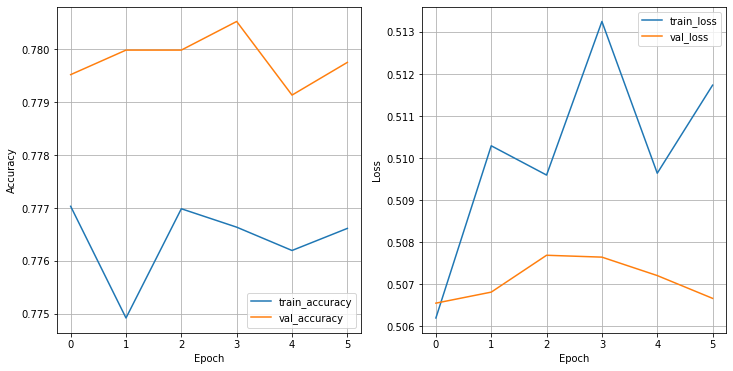

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
reconstructed_model.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files
files.download('dnt.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11-th round = 110 epochs

In [ ]:
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=X_train[0].shape, classifier_activation = "sofmax")

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = True
#base_model.summary()

reconstructed_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

num_epochs = 10
print('------- Training -------')
start = time.time()
history = reconstructed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - 1112s 3s/step - loss: 0.5193 - categorical_accuracy: 0.7765 - val_loss: 0.5102 - val_categorical_accuracy: 0.7788 - lr: 1.0000e-05
Epoch 2/10
337/337 [==============================] - 1107s 3s/step - loss: 0.5130 - categorical_accuracy: 0.7787 - val_loss: 0.5057 - val_categorical_accuracy: 0.7805 - lr: 1.0000e-05
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 0.5183 - categorical_accuracy: 0.7781

337/337 [==============================] - 1143s 3s/step - loss: 0.5183 - categorical_accuracy: 0.7781 - val_loss: 0.5059 - val_categorical_accuracy: 0.7821 - lr: 1.0000e-05
Epoch 4/10
337/337 [==============================] - 1109s 3s/step - loss: 0.5175 - categorical_accuracy: 0.7786 - val_loss: 0.5177 - val_categorical_accuracy: 0.7799 - lr: 1.0000e-05
Epoch 5/10
337/337 [==============================] - ETA: 0s - loss: 0.5126 - categorical_accuracy: 0.7782

337/337 [==============================] - 1133s 3s/step - loss: 0.5126 - categorical_accuracy: 0.7782 - val_loss: 0.5132 - val_categorical_accuracy: 0.7833 - lr: 2.0000e-06
Epoch 6/10
337/337 [==============================] - 1116s 3s/step - loss: 0.5141 - categorical_accuracy: 0.7799 - val_loss: 0.5132 - val_categorical_accuracy: 0.7822 - lr: 2.0000e-06
Epoch 7/10
337/337 [==============================] - 1121s 3s/step - loss: 0.5164 - categorical_accuracy: 0.7795 - val_loss: 0.5108 - val_categorical_accuracy: 0.7817 - lr: 2.0000e-06
Epoch 7: early stopping
Total training took 2.18 hours.


In [ ]:
#test the model

results = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 104s 596ms/step - loss: 0.4792 - categorical_accuracy: 0.7911
Test accuracy: 0.791


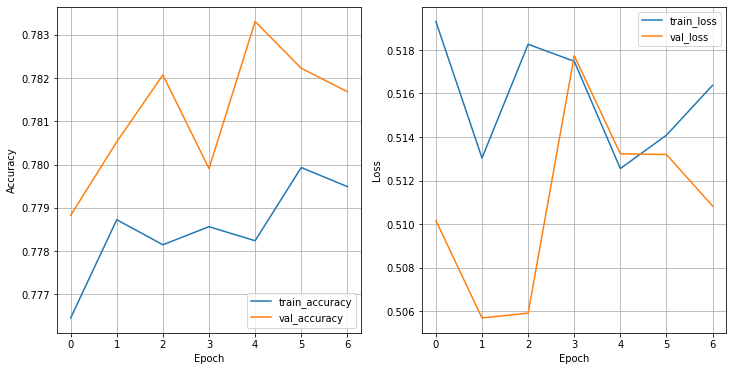

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
# save model and architecture to single file
reconstructed_model.save("dnt.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files
files.download('dnt.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12-th round: still improving? 

We reached convergence of the trainable parameters

In [ ]:
print('------- Training -------')
start = time.time()
history = reconstructed_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/10
337/337 [==============================] - 1132s 3s/step - loss: 0.5108 - categorical_accuracy: 0.7786 - val_loss: 0.5102 - val_categorical_accuracy: 0.7828 - lr: 2.0000e-06
Epoch 2/10
337/337 [==============================] - 1112s 3s/step - loss: 0.5119 - categorical_accuracy: 0.7787 - val_loss: 0.5115 - val_categorical_accuracy: 0.7818 - lr: 2.0000e-06
Epoch 3/10
337/337 [==============================] - 1124s 3s/step - loss: 0.5108 - categorical_accuracy: 0.7759 - val_loss: 0.5128 - val_categorical_accuracy: 0.7822 - lr: 2.0000e-06
Epoch 4/10
337/337 [==============================] - 1104s 3s/step - loss: 0.5120 - categorical_accuracy: 0.7790 - val_loss: 0.5145 - val_categorical_accuracy: 0.7832 - lr: 1.0000e-06
Epoch 5/10
337/337 [==============================] - 1116s 3s/step - loss: 0.5131 - categorical_accuracy: 0.7777 - val_loss: 0.5136 - val_categorical_accuracy: 0.7825 - lr: 1.0000e-06
Epoch 6/10
337/337 [==============================

In [ ]:
#test the model

results = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))

174/174 [==============================] - 108s 621ms/step - loss: 0.4775 - categorical_accuracy: 0.7905
Test accuracy: 0.791


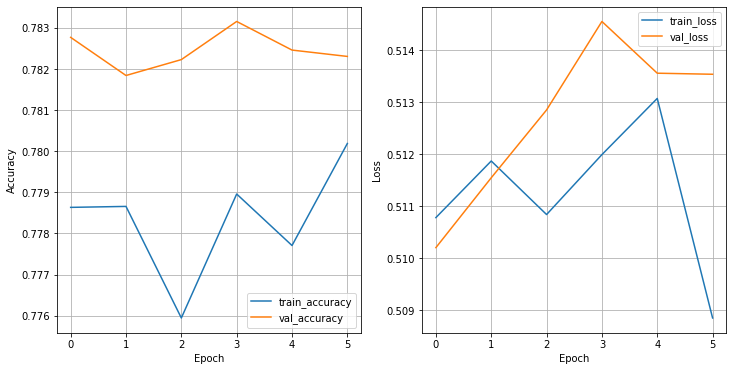

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['categorical_accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_categorical_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

In [ ]:
preds = reconstructed_model.predict(X_test)

In [ ]:
array_pred = np.argmax(preds, axis =1)
array_true = np.argmax(y_test, axis =1)

In [ ]:
misclass = []
for num in range(len(y_test)):
    if (array_pred[num] != array_true[num]):
        misclass.append(num)

Misclassified images


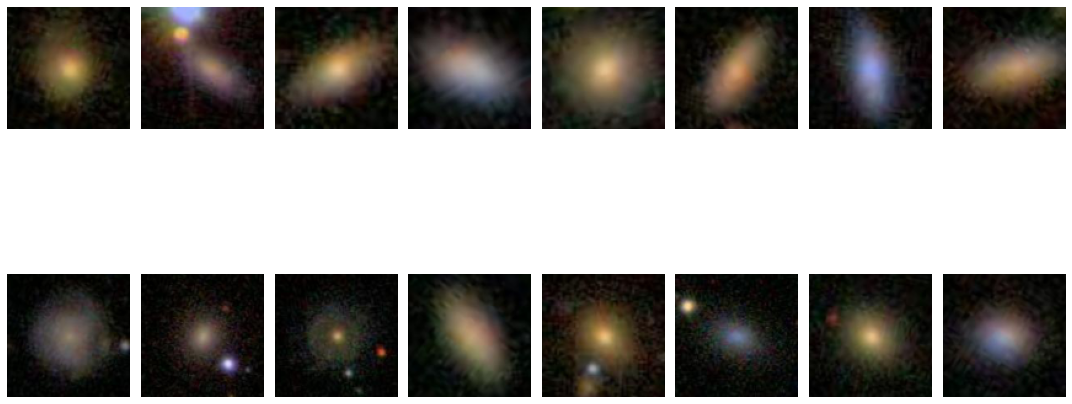

In [ ]:
print("Misclassified images")
fig = plt.figure(figsize= (15,15))
position = 1
for i in misclass[:16]:
  fig.add_subplot(2, 8, position)
  plt.imshow(X_test[i])
  plt.axis('off')
  plt.tight_layout()
  position +=1

Not getting better, we could try with fine tuning and see the result. Can we get to 80%?

# Model [Run this: model file available on github]

In [ ]:
#Upload the file with the saved architecture and weights (download from github)

from google.colab import files
restored = files.upload()

In [ ]:
loaded_model = keras.models.load_model("dnt.h5")

In [ ]:
#num_epochs = 10
#verbose = True
#
## Callbacks
#reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
#
#lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)
#
#early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#
#checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_categorical_accuracy', mode='max')   
#
#callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

In [ ]:
#print('------- Training -------')
#start = time.time()
#history = loaded_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size = BATCH_SIZE, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
#end = time.time()
#print("Total training took {:.2f} hours.".format((end - start)/3600))

In [ ]:
#test the model

results = loaded_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy: {:.3f}".format(results[1]))